## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize ##scipy optimize
import csv
import time  
#import or_gym
#from or_gym.utils import create_env
import ray
import ray.rllib.agents.ppo as ppo
from ray import tune
from datetime import datetime
sns.set_style("darkgrid")
sns.set_palette("rainbow")
sns.set_context("talk")

In [2]:
import SupplyChain_gym

In [3]:
from ray.tune.registry import register_env

In [4]:
# from SupplyChain_gym.envs.InventoryEnvFile import InventoryEnv
# from SupplyChain_gym.envs.NetworkManagementFile import NetInvMgmtMasterEnv
# from SupplyChain_gym.envs.NetworkManagementFile import NetInvMgmtBacklogEnv as backlog_env
# from SupplyChain_gym.envs.NetworkManagementFile import NetInvMgmtLostSalesEnv as lost_sales_env

In [5]:
from SupplyChain_gym.envs.InventoryManagementFile import InvManagementMasterEnv
from SupplyChain_gym.envs.InventoryManagementFile import InvManagementBacklogEnv as backlog_env
from SupplyChain_gym.envs.InventoryManagementFile import InvManagementLostSalesEnv as lost_sales_env

In [6]:
from scipy.optimize import minimize

In [7]:
from gym import spaces

In [8]:
import os
import math
import random

In [9]:
from matplotlib import gridspec
import networkx as nx

## Inventory Management with default parameters

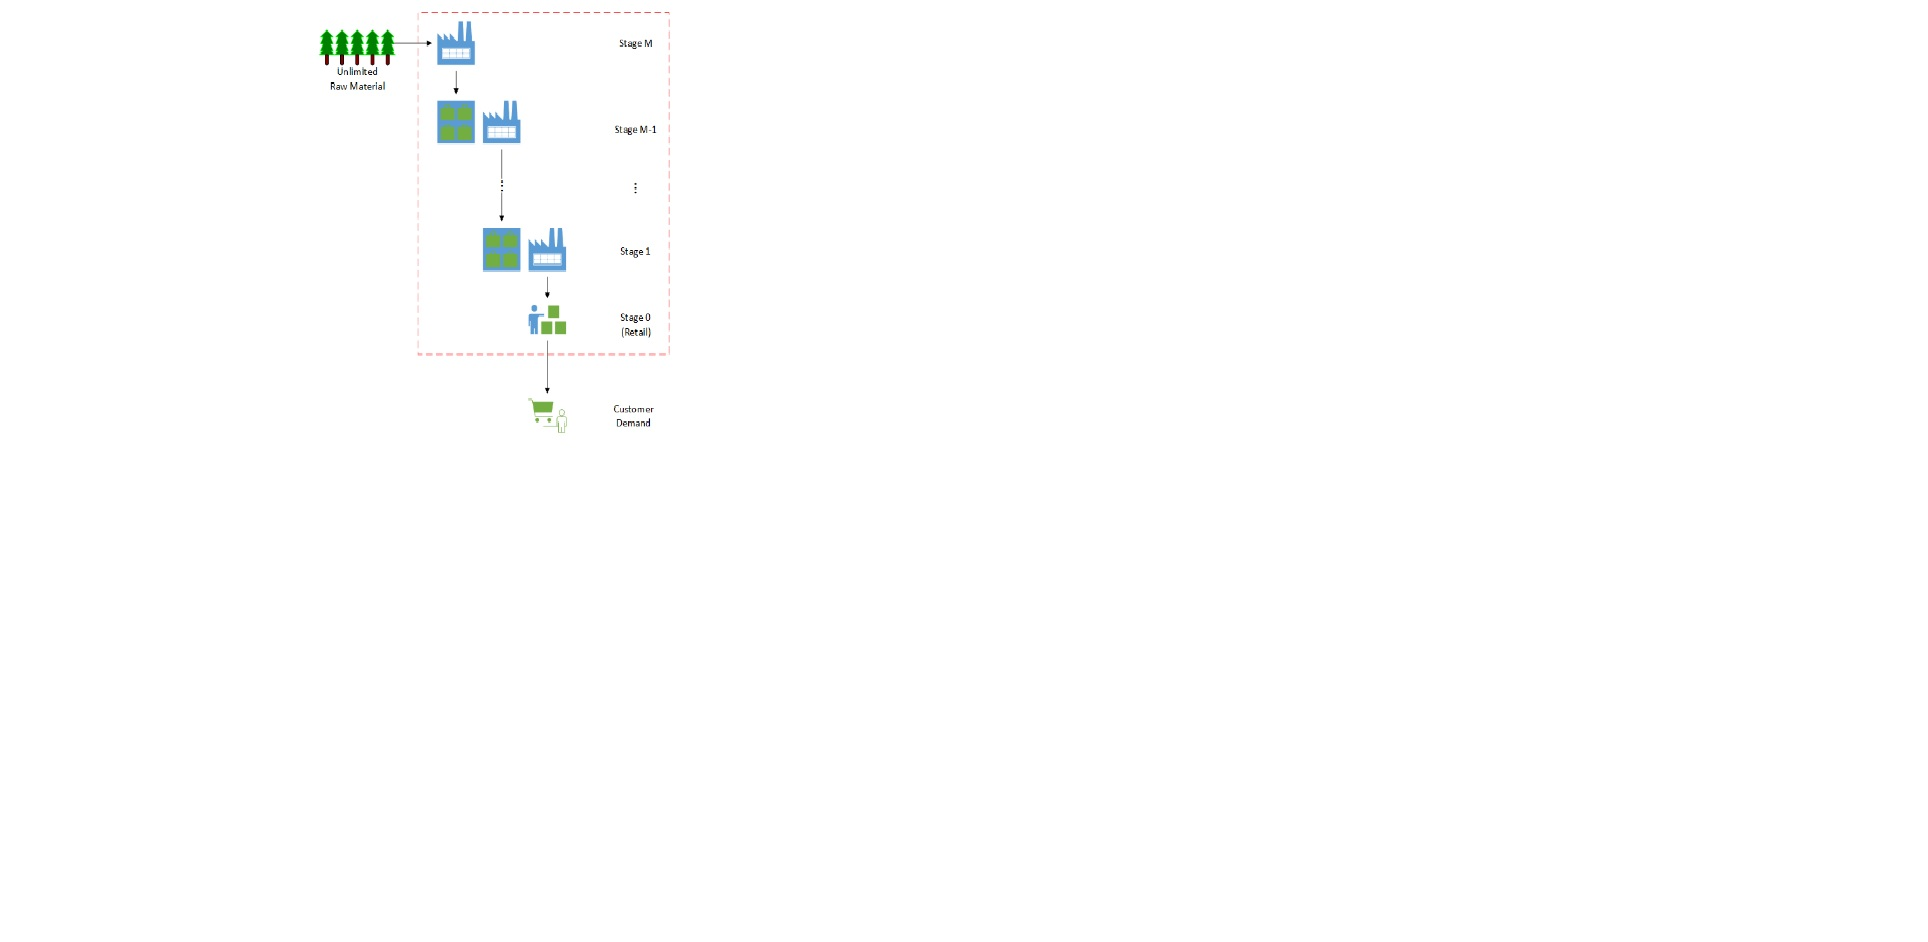

### Running with ray

In [ ]:
CHECKPOINT_ROOT = r"C:\Users\kishore.kukreja\Desktop\Inventory Policy Two Echelon\multi-echelon-RL\model\inventorymanagementv1\default"

In [ ]:
ray.shutdown()
ray.init(ignore_reinit_error=True,local_mode=True)

In [ ]:
import os
import shutil
if not os.path.exists(CHECKPOINT_ROOT):
    os.makedirs(CHECKPOINT_ROOT)

In [ ]:
# shutil.rmtree(CHECKPOINT_ROOT, ignore_errors=True, onerror=None)
# ray_results = os.getcwd() + "/ray_results/"
# shutil.rmtree(ray_results, ignore_errors=True, onerror=None)

In [ ]:
config = ppo.DEFAULT_CONFIG.copy()
config
config["log_level"] = "DEBUG"

In [ ]:
# def register_env(env_name):
#     env = create_env(env_name)
#     tune.register_env(env_name, 
#         lambda env_name: env(env_name))

In [ ]:
# env_name = 'SupplyChainEnv-v0'
# # Register environment
# register_env(env_name)

In [ ]:
# env = InventoryEnv(case, case.action_low, case.action_high,
#                        case.action_min, case.action_max, case.state_low, case.state_high,
#                        'DRL', fix=True)

In [ ]:
select_env = "InventoryManagement-v1" #NetworkManagement-v1 #NetworkManagement-v2 #SupplyChainEnv-v0

In [ ]:
# register_env(select_env, lambda config: InventoryEnv(case, case.action_low, case.action_high,
#                        case.action_min, case.action_max, case.state_low, case.state_high,
#                        'DRL', fix=True))

In [ ]:
case=InvManagementMasterEnv()

In [ ]:
register_env(select_env,lambda config :backlog_env(case))

In [ ]:
agent = ppo.PPOTrainer(config, env=select_env)

In [ ]:
# import gym
# m=4
# lt_max=10
# supply_capacity=np.array([10,20,30])
# num_periods=30
# pipeline_length = (m-1)*(lt_max+1)
# action_space = gym.spaces.Box(
#     low=np.zeros(m-1), high=np.ones(len(supply_capacity))*np.max(supply_capacity)*num_periods, dtype=np.int16)
# # observation space (Inventory position at each echelon, which is any integer value)
# observation_space = gym.spaces.Box(
#     low=-np.ones(pipeline_length)*supply_capacity.max()*num_periods*10,
#     high=np.ones(pipeline_length)*supply_capacity.max()*num_periods, dtype=np.int32)
# action_space,observation_space
# low_ = np.min(action_space.low)
# high_ = np.max(action_space.high)
# assert np.all(action_space.high == high_)

In [ ]:
# rl_config = dict(
#     env=env_name,
#     num_workers=2,
#     env_config=env_config,
#     model=dict(
#         vf_share_layers=False,
#         fcnet_activation='elu',
#         fcnet_hiddens=[256, 256]
#     ),
#     lr=1e-5
# )

In [ ]:
N_ITER = 1
#s = "{:3d} reward {:6.2f}/{:6.2f}/{:6.2f} len {:6.2f} saved {}"

In [ ]:
results=[]
for n in range(N_ITER):
    result = agent.train()
    results.append(result)
    file_name = agent.save(CHECKPOINT_ROOT)
    print(file_name)
    print(result)

In [ ]:
# Unpack values from each iteration
rewards = np.hstack([i['hist_stats']['episode_reward'] 
    for i in results])
# pol_loss = [
#     i['info']['learner']['default_policy']['policy_loss'] 
#     for i in results]
# vf_loss = [
#     i['info']['learner']['default_policy']['vf_loss'] 
#     for i in results]

In [ ]:
p = 100
mean_rewards = np.array([np.mean(rewards[i-p:i+1]) 
                if i >= p else np.mean(rewards[:i+1]) 
                for i, _ in enumerate(rewards)])
std_rewards = np.array([np.std(rewards[i-p:i+1])
               if i >= p else np.std(rewards[:i+1])
               for i, _ in enumerate(rewards)])

In [ ]:
mean_rewards,std_rewards

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(20, 10))
gs = fig.add_gridspec(2, 4)
ax0 = fig.add_subplot(gs[:, :-2])
ax0.fill_between(np.arange(len(mean_rewards)), 
                 mean_rewards - std_rewards, 
                 mean_rewards + std_rewards, 
                 label='Standard Deviation', alpha=0.3)
ax0.plot(mean_rewards, label='Mean Rewards')
ax0.set_ylabel('Rewards')
ax0.set_xlabel('Episode')
ax0.set_title('Training Rewards')
ax0.legend()

### Predict using checkpoint

In [ ]:
def newest(path):
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    return max(paths, key=os.path.getctime)

In [ ]:
import gym

In [ ]:
newest(CHECKPOINT_ROOT)

In [ ]:
chkpt_file=r'C:\Users\kishore.kukreja\Desktop\Inventory Policy Two Echelon\multi-echelon-RL\model\inventorymanagementv1\default\checkpoint_000001\checkpoint-1'
agent.restore(chkpt_file)

In [ ]:
env = gym.make(select_env)
state = env.reset()

In [ ]:
state

In [ ]:
sum_reward = 0
n_step = 30
reward_list=[]
for step in range(n_step):
    print('Step',step)
    action = agent.compute_action(state)
    state, reward, done, info = env.step(action)
    reward_list.append(reward)
    sum_reward += reward
    print('Step Reward',reward)
    print('Sum Reward',sum_reward)
    print('Next State',state)
    #env.render()
    if done == 1:
        print(f'Final Cumulative Reward:{sum_reward:.3f}')
        state = env.reset()
        sum_reward = 0

In [ ]:
plt.figure(figsize=(18, 5))
plt.plot(reward_list)
plt.title('Step Wise Reward')
plt.show()

## Use Derivative Free Powell to Train Agent and Learn

### Powell Derivative free

In [ ]:
def base_stock_policy(policy, env):
    '''
    Implements a re-order up-to policy. This means that for
    each node in the network, if the inventory at that node 
    falls below the level denoted by the policy, we will 
    re-order inventory to bring it to the policy level.
    
    For example, policy at a node is 10, current inventory
    is 5: the action is to order 5 units.
    '''
    assert len(policy) == len(env.init_inv), (
        'Policy should match number of nodes in network' + 
        '({}, {}).'.format(
            len(policy), len(env.init_inv)))
    
    # Get echelon inventory levels
    if env.period == 0:
        inv_ech = np.cumsum(env.I[env.period] +
            env.T[env.period])
    else:
        inv_ech = np.cumsum(env.I[env.period] +
            env.T[env.period] - env.B[env.period-1, :-1])
        
    # Get unconstrained actions
    unc_actions = policy - inv_ech
    unc_actions = np.where(unc_actions>0, unc_actions, 0)
    
    # Ensure that actions can be fulfilled by checking 
    # constraints
    inv_const = np.hstack([env.I[env.period, 1:], np.Inf])
    actions = np.minimum(env.c,
                np.minimum(unc_actions, inv_const))
    return actions

In [ ]:
def dfo_func(policy, env, *args):
    '''
    Runs an episode based on current base-stock model 
    settings. This allows us to use our environment for the 
    DFO optimizer.
    '''
    env.reset() # Ensure env is fresh
    rewards = []
    done = False
    while not done:
        action = base_stock_policy(policy, env)
        state, reward, done, _ = env.step(action)
        rewards.append(reward)
        if done:
            break
            
    rewards = np.array(rewards)
    prob = env.demand_dist.pmf(env.D, **env.dist_param)
    
    # Return negative of expected profit
    return -1 / env.num_periods * np.sum(prob * rewards)

In [ ]:
def optimize_inventory_policy(env_name, fun,
    init_policy=None, env_config={}, method='Powell'):
    
    env = gym.make(env_name, env_config=env_config)
    
    if init_policy is None:
        init_policy = np.ones(env.num_stages-1)
        
    # Optimize policy
    out = minimize(fun=fun, x0=init_policy, args=env, 
        method=method)
    policy = out.x.copy()
    
    # Policy must be positive integer
    policy = np.round(np.maximum(policy, 0), 0).astype(int)
    
    return policy, out

In [ ]:
select_env='InventoryManagement-v1'

In [ ]:
policy, out = optimize_inventory_policy(select_env,
    dfo_func)
print("Re-order levels: {}".format(policy))
print("DFO Info:\n{}".format(out))

In [ ]:
env_config={}
env = gym.make(select_env, env_config=env_config)
eps = 1000
rewards = []
for i in range(eps):
    env.reset()
    reward = 0
    while True:
        action = base_stock_policy(policy, env)
        s, r, done, _ = env.step(action)
        reward += r
        if done:
            rewards.append(reward)
            break

In [ ]:
plt.figure(figsize=(18, 5))
num_bins = 10
rewards=np.array(rewards)
n, bins, patches = plt.hist(rewards, num_bins, facecolor='red', alpha=0.5)
plt.title('Episode Wise Reward')
plt.axvline(rewards.mean(), color='k', linestyle='dashed', linewidth=3)
min_ylim, max_ylim = plt.ylim()
plt.text(rewards.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(rewards.mean()))
plt.show()

## Inventory Management with User Input parameters

### Default Network

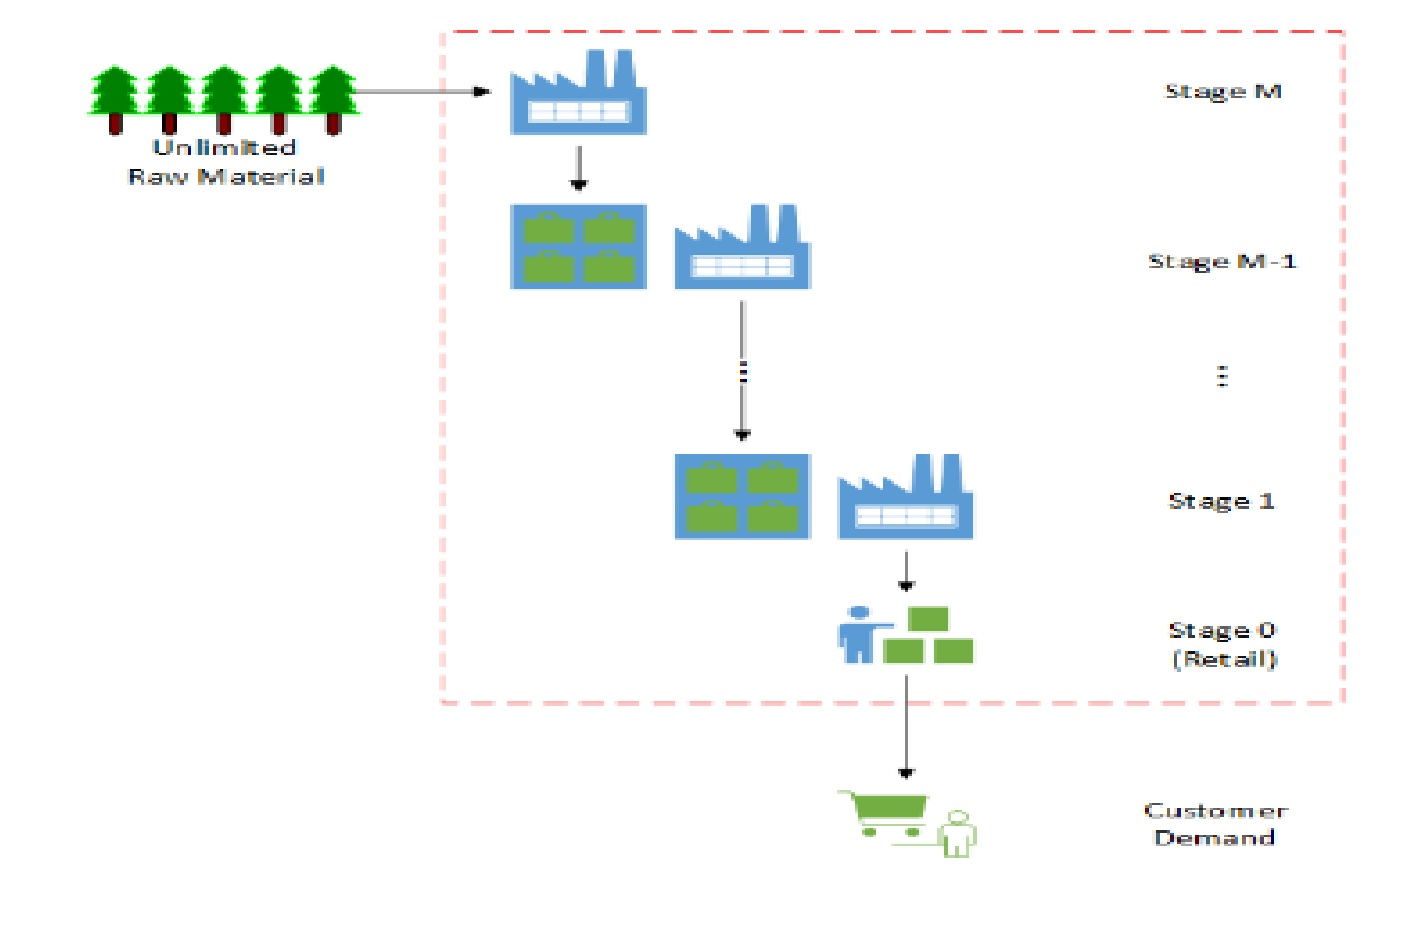

### Backlog - Back Orders

In [ ]:
from scipy.stats import poisson

In [ ]:
periods = 30
I0 = [100, 100, 200]
p = 2
r = [1.5, 1.0, 0.75, 0.5]
k = [0.10, 0.075, 0.05, 0.025]
h = [0.15, 0.10, 0.05]
c = [100, 90, 80]
L = [3, 5, 10]
backlog = True
dist = 1
dist_param = {'mu': 20}
alpha = 0.97
seed_int = 0
user_D = np.zeros(periods)
_max_rewards = 2000

In [ ]:
CHECKPOINT_ROOT = r"C:\Users\kishore.kukreja\Desktop\Inventory Policy Two Echelon\multi-echelon-RL\model\inventorymanagementv1\userdefined\backorder"

In [ ]:
ray.shutdown()
ray.init(ignore_reinit_error=True,local_mode=True)

In [ ]:
import os
import shutil
if not os.path.exists(CHECKPOINT_ROOT):
    os.makedirs(CHECKPOINT_ROOT)

In [ ]:
config = ppo.DEFAULT_CONFIG.copy()
config
config["log_level"] = "DEBUG"

In [ ]:
select_env = "InventoryManagement-v1" #NetworkManagement-v1 #NetworkManagement-v2 #SupplyChainEnv-v0 #InventoryManagement-v1 #InventoryManagement-v2

In [ ]:
## This is a 4 stage network 0 being retailer 1 WH (with production &storage capacity) 2 is Manufacturer (with production &storage capacity) 
## 3 is raw material or supplier with unlimited inventory 
periods = 30
I0 = [100, 100, 200] # I0 = [non-negative integer; dimension |Stages|-1] initial inventories for each stage. Stage M has infite inventory so not tracked here
p = 2 # p = [positive float] unit price for final product.
r = [1.5, 1.0, 0.75, 0.5] #r = [non-negative float; dimension |Stages|] unit cost for replenishment orders at each stage.
k = [0.10, 0.075, 0.05, 0.025] #k = [non-negative float; dimension |Stages|] backlog cost or goodwill loss (per unit) for unfulfilled orders (demand or replenishment orders).
h = [0.15, 0.10, 0.05]  #h = [non-negative float; dimension |Stages|-1] unit holding cost for excess on-hand inventory at each stage.
c = [100, 90, 80] #c = [positive integer; dimension |Stages|-1] production capacities for each suppliers (stages 1 through |Stage|).
L = [3, 5, 10] #L = [non-negative integer; dimension |Stages|-1] lead times in betwen stages.
backlog = True #backlog = [boolean] are unfulfilled orders backlogged? True = backlogged, False = lost sales.
dist = 1
# dist = [integer] value between 1 and 4. Specifies distribution for customer demand.
#             1: poisson distribution
#             2: binomial distribution
#             3: uniform random integer
#             4: geometric distribution
#             5: user supplied demand values
dist_param = {'mu': 20}
# dist_param = [dictionary] named values for parameters fed to statistical distribution.
#             poisson: {'mu': <mean value>}
#             binom: {'n': <mean value>, 'p': <probability between 0 and 1 of getting the mean value>}
#             raindint: {'low' = <lower bound>, 'high': <upper bound>}
#             geom: {'p': <probability. Outcome is the number of trials to success>}
alpha = 0.97 #alpha = [float in range (0,1]] discount factor to account for the time value of money
seed_int = 0 #seed_int = [integer] seed for random state.
user_D = np.zeros(periods) #user_D = [list] user specified demand for each time period in simulation
_max_rewards = 2000

In [ ]:
env_config = {'periods': periods,
              '_max_rewards': _max_rewards,
              'alpha': alpha,
              'seed_int': seed_int,
              'backlog': backlog,
              'user_D': user_D,
              'I0': I0,
              'p': p,
              'r': r,
              'k': k,
              'h': h,
              'c': c,
              'L': L
             }
env_config

In [ ]:
case=InvManagementMasterEnv()

In [ ]:
register_env(select_env,lambda config :backlog_env(case,env_config=env_config))

In [ ]:
agent = ppo.PPOTrainer(config, env=select_env)

In [ ]:
N_ITER=1 ## Increase later
results=[]
for n in range(N_ITER):
    result = agent.train()
    results.append(result)
    file_name = agent.save(CHECKPOINT_ROOT)
    print(file_name)
    print(result)

In [ ]:
# Unpack values from each iteration
rewards = np.hstack([i['hist_stats']['episode_reward'] 
    for i in results])
# pol_loss = [
#     i['info']['learner']['default_policy']['policy_loss'] 
#     for i in results]
# vf_loss = [
#     i['info']['learner']['default_policy']['vf_loss'] 
#     for i in results]

In [ ]:
p = 100
mean_rewards = np.array([np.mean(rewards[i-p:i+1]) 
                if i >= p else np.mean(rewards[:i+1]) 
                for i, _ in enumerate(rewards)])
std_rewards = np.array([np.std(rewards[i-p:i+1])
               if i >= p else np.std(rewards[:i+1])
               for i, _ in enumerate(rewards)])

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(20, 10))
gs = fig.add_gridspec(2, 4)
ax0 = fig.add_subplot(gs[:, :-2])
ax0.fill_between(np.arange(len(mean_rewards)), 
                 mean_rewards - std_rewards, 
                 mean_rewards + std_rewards, 
                 label='Standard Deviation', alpha=0.3)
ax0.plot(mean_rewards, label='Mean Rewards')
ax0.set_ylabel('Rewards')
ax0.set_xlabel('Episode')
ax0.set_title('Training Rewards')
ax0.legend()

### Lost Sales

In [ ]:
from scipy.stats import poisson

In [ ]:
## This is a 4 stage network 0 being retailer 1 WH (with production &storage capacity) 2 is Manufacturer (with production &storage capacity) 
## 3 is raw material or supplier with unlimited inventory 
periods = 30
I0 = [100, 100, 200] # I0 = [non-negative integer; dimension |Stages|-1] initial inventories for each stage. Stage M has infite inventory so not tracked here
p = 2 # p = [positive float] unit price for final product.
r = [1.5, 1.0, 0.75, 0.5] #r = [non-negative float; dimension |Stages|] unit cost for replenishment orders at each stage.
k = [0.10, 0.075, 0.05, 0.025] #k = [non-negative float; dimension |Stages|] backlog cost or goodwill loss (per unit) for unfulfilled orders (demand or replenishment orders).
h = [0.15, 0.10, 0.05]  #h = [non-negative float; dimension |Stages|-1] unit holding cost for excess on-hand inventory at each stage.
c = [100, 90, 80] #c = [positive integer; dimension |Stages|-1] production capacities for each suppliers (stages 1 through |Stage|).
L = [3, 5, 10] #L = [non-negative integer; dimension |Stages|-1] lead times in betwen stages.
backlog = False #backlog = [boolean] are unfulfilled orders backlogged? True = backlogged, False = lost sales.
dist = 1
# dist = [integer] value between 1 and 4. Specifies distribution for customer demand.
#             1: poisson distribution
#             2: binomial distribution
#             3: uniform random integer
#             4: geometric distribution
#             5: user supplied demand values
dist_param = {'mu': 20}
# dist_param = [dictionary] named values for parameters fed to statistical distribution.
#             poisson: {'mu': <mean value>}
#             binom: {'n': <mean value>, 'p': <probability between 0 and 1 of getting the mean value>}
#             raindint: {'low' = <lower bound>, 'high': <upper bound>}
#             geom: {'p': <probability. Outcome is the number of trials to success>}
alpha = 0.97 #alpha = [float in range (0,1]] discount factor to account for the time value of money
seed_int = 0 #seed_int = [integer] seed for random state.
user_D = np.zeros(periods) #user_D = [list] user specified demand for each time period in simulation
_max_rewards = 2000

In [ ]:
CHECKPOINT_ROOT = r"C:\Users\kishore.kukreja\Desktop\Inventory Policy Two Echelon\multi-echelon-RL\model\inventorymanagementv1\userdefined\lostsales"

In [ ]:
ray.shutdown()
ray.init(ignore_reinit_error=True,local_mode=True)

In [ ]:
import os
import shutil
if not os.path.exists(CHECKPOINT_ROOT):
    os.makedirs(CHECKPOINT_ROOT)

In [ ]:
config = ppo.DEFAULT_CONFIG.copy()
config
config["log_level"] = "DEBUG"

In [ ]:
select_env = "InventoryManagement-v2" #NetworkManagement-v1 #NetworkManagement-v2 #SupplyChainEnv-v0

In [ ]:
env_config = {'periods': periods,
              '_max_rewards': _max_rewards,
              'alpha': alpha,
              'seed_int': seed_int,
              'backlog': backlog,
              'user_D': user_D,
              'I0': I0,
              'p': p,
              'r': r,
              'k': k,
              'h': h,
              'c': c,
              'L': L
             }
env_config

In [ ]:
case=InvManagementMasterEnv()

In [ ]:
register_env(select_env,lambda config :lost_sales_env(case,env_config=env_config))

In [ ]:
agent = ppo.PPOTrainer(config, env=select_env)

In [ ]:
N_ITER=1 ## Increase later
results=[]
for n in range(N_ITER):
    result = agent.train()
    results.append(result)
    file_name = agent.save(CHECKPOINT_ROOT)
    print(file_name)
    print(result)

In [ ]:
# Unpack values from each iteration
rewards = np.hstack([i['hist_stats']['episode_reward'] 
    for i in results])
# pol_loss = [
#     i['info']['learner']['default_policy']['policy_loss'] 
#     for i in results]
# vf_loss = [
#     i['info']['learner']['default_policy']['vf_loss'] 
#     for i in results]

In [ ]:
p = 100
mean_rewards = np.array([np.mean(rewards[i-p:i+1]) 
                if i >= p else np.mean(rewards[:i+1]) 
                for i, _ in enumerate(rewards)])
std_rewards = np.array([np.std(rewards[i-p:i+1])
               if i >= p else np.std(rewards[:i+1])
               for i, _ in enumerate(rewards)])

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(20, 10))
gs = fig.add_gridspec(2, 4)
ax0 = fig.add_subplot(gs[:, :-2])
ax0.fill_between(np.arange(len(mean_rewards)), 
                 mean_rewards - std_rewards, 
                 mean_rewards + std_rewards, 
                 label='Standard Deviation', alpha=0.3)
ax0.plot(mean_rewards, label='Mean Rewards')
ax0.set_ylabel('Rewards')
ax0.set_xlabel('Episode')
ax0.set_title('Training Rewards')
ax0.legend()

### Change Network and Parameters

In [10]:
# Make a 5 stage network // 0 Retailer- 1 RDC- 2 DC - 3 Manufacturer -4 Raw materials(supplier)
# No production capcity for either RDC or DC
# No Storage capacity for Manufacturer
# User_D i.e. customer to reatiker demand should be cyclic now which should be a input

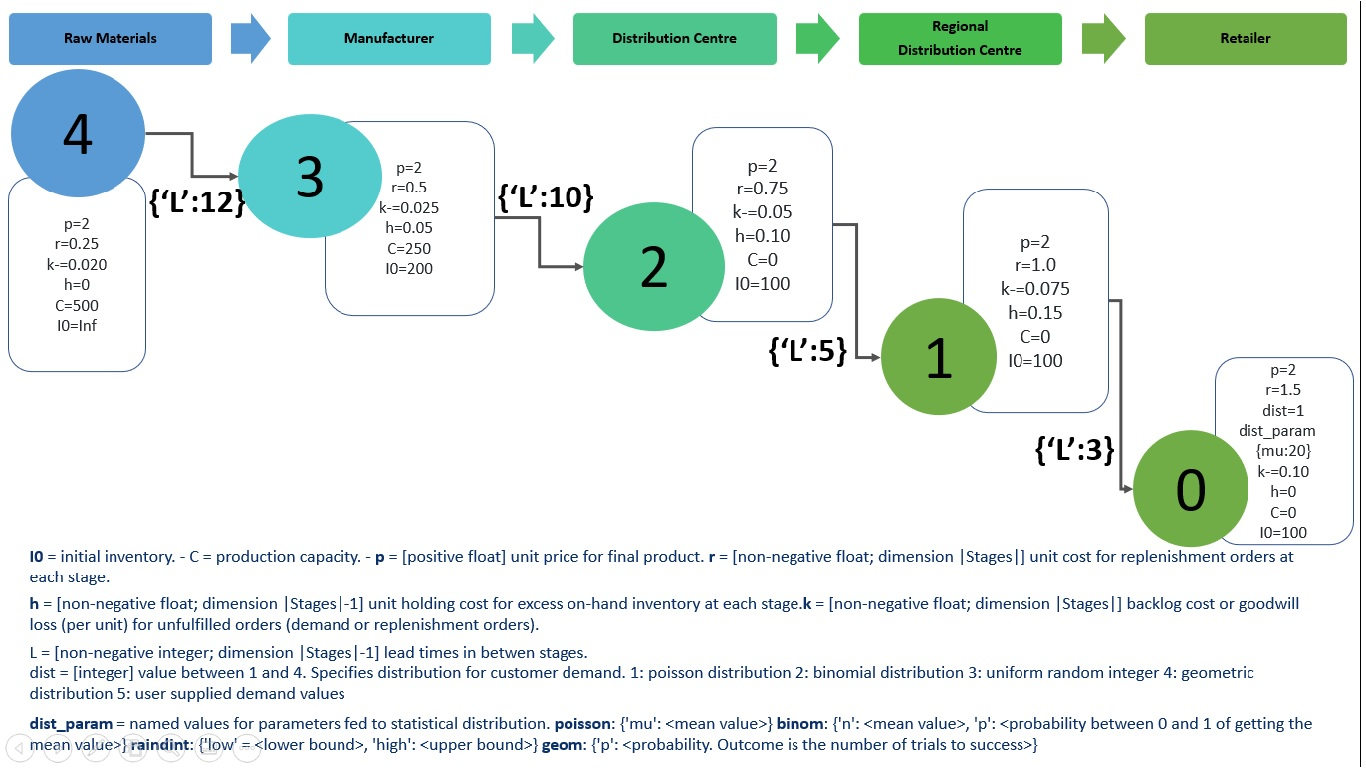

In [11]:
from scipy.stats import poisson

In [12]:
# # Save user_D and sample_path to graph metadata
# for link in user_D.keys():
#     d = user_D[link]
#     if np.sum(d) != 0:
#         graph.edges[link]['user_D'] = d
#         if link in sample_path.keys():
#             graph.edges[link]['sample_path'] = sample_path[link]
#     else:
#         # Placeholder to avoid key errors
#         graph.edges[link]['user_D'] = 0

In [13]:
# graph.edges[(3,1)]

In [14]:
# market = [j for j in graph.nodes() if len(list(graph.successors(j))) == 0]
# distrib = [j for j in graph.nodes() if 'C' not in graph.nodes[j] and 'I0' in graph.nodes[j]]
# retail = [j for j in graph.nodes() if len(set.intersection(set(graph.successors(j)), set(market))) > 0]

In [15]:
# graph.has_edge(3,0)

In [16]:
# for j in retail:
#     for k in market:
#         print(j,k)
#         if graph.has_edge(j,k):
#             print('Has edge')
#             Demand = graph.edges[(j,k)]['user_D']
        

In [17]:
CHECKPOINT_ROOT = r"C:\Users\kishore.kukreja\Desktop\Inventory Policy Two Echelon\multi-echelon-RL\model\inventorymanagementv1\userdefined\lostsales"

In [18]:
ray.shutdown()
ray.init(ignore_reinit_error=True,local_mode=True)

{'node_ip_address': '192.168.0.25',
 'raylet_ip_address': '192.168.0.25',
 'redis_address': '192.168.0.25:6379',
 'object_store_address': 'tcp://127.0.0.1:65131',
 'raylet_socket_name': 'tcp://127.0.0.1:64531',
 'webui_url': None,
 'session_dir': 'C:\\Users\\KISHOR~1.KUK\\AppData\\Local\\Temp\\ray\\session_2021-10-20_18-35-34_506590_10748',
 'metrics_export_port': 64337,
 'node_id': 'df5c2f9d6c6ffa4e0aaa6f1a583cbb7e4c36ce5f02f1a71827709beb'}

In [19]:
import os
import shutil
if not os.path.exists(CHECKPOINT_ROOT):
    os.makedirs(CHECKPOINT_ROOT)

In [20]:
config = ppo.DEFAULT_CONFIG.copy()
config
config["log_level"] = "DEBUG"

In [21]:
select_env = "InventoryManagement-v1" #NetworkManagement-v1 #NetworkManagement-v2 #SupplyChainEnv-v0 #"InventoryManagement-v1" #InventoryManagement-v2

In [22]:
## This is a 4 stage network 0 being retailer 1 WH (with production &storage capacity) 2 is Manufacturer (with production &storage capacity) 
## 3 is raw material or supplier with unlimited inventory 
periods = 30
I0 = [100, 100, 100,200] # I0 = [non-negative integer; dimension |Stages|-1] initial inventories for each stage. Stage M has infite inventory so not tracked here
p = 2 # p = [positive float] unit price for final product.
r = [1.5, 1.0, 0.75, 0.5,0.25] #r = [non-negative float; dimension |Stages|] unit cost for replenishment orders at each stage.
k = [0.10, 0.075, 0.05, 0.025, 0.020] #k = [non-negative float; dimension |Stages|] backlog cost or goodwill loss (per unit) for unfulfilled orders (demand or replenishment orders).
h = [0.15, 0.10, 0.05,0.0]  #h = [non-negative float; dimension |Stages|-1] unit holding cost for excess on-hand inventory at each stage.
c = [1, 1, 250,500] #c = [positive integer; dimension |Stages|-1] production capacities for each suppliers (stages 1 through |Stage|).
L = [3, 5, 10,12] #L = [non-negative integer; dimension |Stages|-1] lead times in betwen stages.
backlog = False #backlog = [boolean] are unfulfilled orders backlogged? True = backlogged, False = lost sales.
dist = 5
# dist = [integer] value between 1 and 4. Specifies distribution for customer demand.
#             1: poisson distribution
#             2: binomial distribution
#             3: uniform random integer
#             4: geometric distribution
#             5: user supplied demand values
dist_param = {'mu': 20}
# dist_param = [dictionary] named values for parameters fed to statistical distribution.
#             poisson: {'mu': <mean value>}
#             binom: {'n': <mean value>, 'p': <probability between 0 and 1 of getting the mean value>}
#             raindint: {'low' = <lower bound>, 'high': <upper bound>}
#             geom: {'p': <probability. Outcome is the number of trials to success>}
alpha = 0.97 #alpha = [float in range (0,1]] discount factor to account for the time value of money
seed_int = 0 #seed_int = [integer] seed for random state.
upper_bound=100
lower_bound=10
user_D = np.random.randint(lower_bound,upper_bound,periods)#np.zeros(periods) #user_D = [list] user specified demand for each time period in simulation
_max_rewards = 2000

In [23]:
env_config = {'periods': periods,
              '_max_rewards': _max_rewards,
              'alpha': alpha,
              'seed_int': seed_int,
              'backlog': backlog,
              'user_D': user_D,
              'I0': I0,
              'p': p,
              'r': r,
              'k': k,
              'h': h,
              'c': c,
              'L': L
             }
env_config

{'periods': 30,
 '_max_rewards': 2000,
 'alpha': 0.97,
 'seed_int': 0,
 'backlog': False,
 'user_D': array([20, 97, 77, 18, 53, 68, 10, 46, 90, 40, 55, 23, 51, 26, 53, 91, 53,
        79, 63, 98, 95, 19, 39, 40, 77, 73, 45, 54, 63, 64]),
 'I0': [100, 100, 100, 200],
 'p': 2,
 'r': [1.5, 1.0, 0.75, 0.5, 0.25],
 'k': [0.1, 0.075, 0.05, 0.025, 0.02],
 'h': [0.15, 0.1, 0.05, 0.0],
 'c': [1, 1, 250, 500],
 'L': [3, 5, 10, 12]}

In [24]:
case=InvManagementMasterEnv()

In [25]:
register_env(select_env,lambda config :backlog_env(case,env_config=env_config))

In [26]:
agent = ppo.PPOTrainer(config, env=select_env)

2021-10-20 18:36:22,236	INFO trainer.py:741 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2021-10-20 18:36:22,236	INFO ppo.py:164 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2021-10-20 18:36:22,422	WARNING worker.py:499 -- `ray.get_gpu_ids()` will always return the empty list when called from the driver. This is because Ray does not manage GPU allocations to the driver process.
2021-10-20 18:36:22,438	INFO rollout_worker.py:1540 -- Validating sub-env at vector index=0 ... (ok)
2021-10-20 18:36:22,438	DEBUG rollout_worker.py:1363 -- Creating policy for default_policy
2021-10-20 18:36:22,456	DEBUG catalog.py:702 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x0000021B7C898FA0>: Box([-150000 -150000 -150000 -150000 -150000 -150000 -150000 -150000 -150000
 -150000 -150000 -150000 -150000 -150000 -150000 

:actor_name:RolloutWorker


2021-10-20 18:36:23,923	INFO tf_policy.py:169 -- TFPolicy (worker=1) running on CPU.
2021-10-20 18:36:25,565	INFO dynamic_tf_policy.py:581 -- Testing `compute_actions` w/ dummy batch.
2021-10-20 18:36:25,580	INFO tf_run_builder.py:86 -- Executing TF run without tracing. To dump TF timeline traces to disk, set the TF_TIMELINE_DIR environment variable.
2021-10-20 18:36:25,758	INFO dynamic_tf_policy.py:589 -- Adding extra-action-fetch `action_prob` to view-reqs.
2021-10-20 18:36:25,758	INFO dynamic_tf_policy.py:589 -- Adding extra-action-fetch `action_logp` to view-reqs.
2021-10-20 18:36:25,758	INFO dynamic_tf_policy.py:589 -- Adding extra-action-fetch `action_dist_inputs` to view-reqs.
2021-10-20 18:36:25,775	INFO dynamic_tf_policy.py:589 -- Adding extra-action-fetch `vf_preds` to view-reqs.
2021-10-20 18:36:25,776	INFO dynamic_tf_policy.py:598 -- Testing `postprocess_trajectory` w/ dummy batch.
2021-10-20 18:36:25,909	DEBUG dynamic_tf_policy.py:629 -- Initializing loss function with dum

:actor_name:RolloutWorker


2021-10-20 18:36:31,925	INFO tf_policy.py:169 -- TFPolicy (worker=2) running on CPU.
2021-10-20 18:36:33,559	INFO dynamic_tf_policy.py:581 -- Testing `compute_actions` w/ dummy batch.
2021-10-20 18:36:33,720	INFO dynamic_tf_policy.py:589 -- Adding extra-action-fetch `action_prob` to view-reqs.
2021-10-20 18:36:33,720	INFO dynamic_tf_policy.py:589 -- Adding extra-action-fetch `action_logp` to view-reqs.
2021-10-20 18:36:33,720	INFO dynamic_tf_policy.py:589 -- Adding extra-action-fetch `action_dist_inputs` to view-reqs.
2021-10-20 18:36:33,739	INFO dynamic_tf_policy.py:589 -- Adding extra-action-fetch `vf_preds` to view-reqs.
2021-10-20 18:36:33,740	INFO dynamic_tf_policy.py:598 -- Testing `postprocess_trajectory` w/ dummy batch.
2021-10-20 18:36:38,450	DEBUG rollout_worker.py:723 -- Created rollout worker with env <ray.rllib.env.base_env._VectorEnvToBaseEnv object at 0x0000021B83ECED60> (<InvManagementBacklogEnv instance>), policies {}
2021-10-20 18:36:38,459	DEBUG rollout_worker.py:136

In [ ]:
N_ITER=1 ## Increase later
results=[]
for n in range(N_ITER):
    result = agent.train()
    results.append(result)
    file_name = agent.save(CHECKPOINT_ROOT)
    print(file_name)
    print(result)
##OOM Memory Retrain on a larger configuration    

In [ ]:
# Unpack values from each iteration
rewards = np.hstack([i['hist_stats']['episode_reward'] 
    for i in results])
# pol_loss = [
#     i['info']['learner']['default_policy']['policy_loss'] 
#     for i in results]
# vf_loss = [
#     i['info']['learner']['default_policy']['vf_loss'] 
#     for i in results]

In [ ]:
p = 100
mean_rewards = np.array([np.mean(rewards[i-p:i+1]) 
                if i >= p else np.mean(rewards[:i+1]) 
                for i, _ in enumerate(rewards)])
std_rewards = np.array([np.std(rewards[i-p:i+1])
               if i >= p else np.std(rewards[:i+1])
               for i, _ in enumerate(rewards)])

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(20, 10))
gs = fig.add_gridspec(2, 4)
ax0 = fig.add_subplot(gs[:, :-2])
ax0.fill_between(np.arange(len(mean_rewards)), 
                 mean_rewards - std_rewards, 
                 mean_rewards + std_rewards, 
                 label='Standard Deviation', alpha=0.3)
ax0.plot(mean_rewards, label='Mean Rewards')
ax0.set_ylabel('Rewards')
ax0.set_xlabel('Episode')
ax0.set_title('Training Rewards')
ax0.legend()

### Next Steps

In [29]:
## get all creative and try to change user_D to be the same length as the num of periods 
## Try with cycclic demand to reflect the true nature of demand 
## Can also try with demand forecast values

In [30]:
## Try to do this for backlog sales i.e. back order sales orders & lost sales

In [31]:
## increase the number of iteartions and retrain to achieve a better model

In [32]:
## Load model from checkpoint and do the inference